In [1]:
!pip install poetry
!pip install ray

     |████████████████████████████████| 174kB 8.2MB/s 
     |████████████████████████████████| 409kB 13.9MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 5.7MB 14.6MB/s 
     |████████████████████████████████| 92kB 10.9MB/s 
     |████████████████████████████████| 337kB 59.2MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
     |████████████████████████████████| 2.6MB 57.2MB/s 
  Found existing installation: importlib-metadata 3.3.0
    Uninstalling importlib-metadata-3.3.0:
      Successfully uninstalled importlib-metadata-3.3.0
     |████████████████████████████████| 48.5MB 65kB/s 
     |████████████████████████████████| 1.3MB 57.5MB/s 
     |████████████████████████████████| 133kB 63.3MB/s 
     |████████████████████████████████| 204kB 59.4MB/s 
     |████████████████████████████████| 71kB 11.6MB/s 
     |████████████████████████████████| 2.9MB 52.7MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/My Drive/DL project'
import sys
sys.path.append(drive_path)

Mounted at /content/drive


# New section

In [3]:
modelName = 'Linearregg'
import datetime
import getpass
import json
import os
import pathlib
from shutil import copyfile

import torch
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from config_Linearregg import code_path, data_path, figure_path, model_path
from src.data import DataframeDataLoader
from src.evaluation_Linearregg import evaluateModel
from src.load_data import dataLoader
from src.models.Linearregg import DilatedNet
from src.parameter_sets.par import *
from src.tools_Linearregg import train_cgm
from pathlib import Path

In [4]:
# %load_ext autoreload
# %autoreload 2

# Paths to data, code, figures, etc. should be set in config.py.
# Initialize the config.py file by copying from config.template.py.
# ---------------------------------------------------------------------
# DEFINE MODEL, PARAMETERS AND DATA
# - Change <par> to the name of file containing your parameters
# - Change <hediaNet> to the name of file containing your model architecture and DilatedNet to the name
#   of your model. Also change in train_cgm and optmizeHypers.py
# ---------------------------------------------------------------------


# Tensorboard log setup
# Create a directory for the model if it doesn't already exist
current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S')
user = getpass.getuser()
model_id = f'id_{current_time}_{user}'
model_path_id = model_path / model_id
model_path_id.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_path_id).mkdir(parents=True, exist_ok=True)
model_figure_path = figure_path / model_id
model_figure_path.mkdir(exist_ok=True, parents=True)
#pathlib.Path(model_figure_path).mkdir(parents=True, exist_ok=True)





In [5]:

# ---------------------------------------------------------------------
# DEFINE DATA
# ---------------------------------------------------------------------
# Define data object
data_pars = {}
data_pars['path'] = data_path
data_pars['train_data'] = train_data
data_pars['test_data'] = test_data
data_pars['validation_data'] = val_data

data_pars['start_date_train'] = start_date_train
data_pars['start_date_test'] = start_date_test
data_pars['start_date_validation'] = start_date_val

data_pars['end_date_train'] = end_date_train
data_pars['end_date_test'] = end_date_test
data_pars['end_date_validation'] = end_date_val


data_obj = dataLoader(data_pars, features, n_steps_past=16,
                      n_steps_future=6,
                      allowed_gap=10,
                      scaler=StandardScaler())


In [6]:
# ---------------------------------------------------------------------
# EXTRACT DATA AND TEST THE MODEL
# ---------------------------------------------------------------------
config = {
    "batch_size": 4,
    "lr": 0.0005408458235742098,
    "h1": 0,
    "h2": 0,
    "wd": 0.045209182824666606,
}


model = DilatedNet(h1=config["h1"],
                   h2=config["h2"])

# model = DilatedNet()

# Load training data
trainset, valset = data_obj.load_train_and_val()

train_loader = DataframeDataLoader(
    trainset,
    batch_size=int(config['batch_size']),
    shuffle=True,
    drop_last=True,
)

# Perform a single prediction
data = next(iter(train_loader))

inputs, targets = data
# It is important to permute the dimensions of the input!!
inputs = Variable(inputs.permute(0, 2, 1)).contiguous()

output= model(inputs)


In [7]:
# ---------------------------------------------------------------------
# TRAING THE MODEL
# ---------------------------------------------------------------------
# Make sure the model archiecture loaded in train_cgm matches the hyper configuration
train_cgm(config, max_epochs=50, grace_period=5,
          n_epochs_stop=15, data_obj=data_obj, useRayTune=False) 
# Load best model
model_state, optimizer_state = torch.load(code_path / 'src' / 'model_state_tmp' / 'checkpoint')
model.load_state_dict(model_state)

# Copy the trained model to model path
copyfile(code_path / 'src' / 'model_state_tmp' / 'checkpoint',
         model_path_id / 'checkpoint')

with open(code_path / 'src' / 'model_state_tmp' / 'hyperPars.json', 'w') as fp:
    json.dump(config, fp)


Saved better model!
Epoch 1, Training loss: 6.03E+02, Validation loss: 1.71E+03
Epoch 2, Training loss: 5.51E+02, Validation loss: 1.72E+03
Epoch 3, Training loss: 5.31E+02, Validation loss: 1.74E+03
Epoch 4, Training loss: 5.18E+02, Validation loss: 1.76E+03
Epoch 5, Training loss: 5.09E+02, Validation loss: 1.79E+03
Epoch 6, Training loss: 5.01E+02, Validation loss: 1.81E+03
Epoch 7, Training loss: 4.94E+02, Validation loss: 1.82E+03
Epoch 8, Training loss: 4.90E+02, Validation loss: 1.84E+03
Epoch 9, Training loss: 4.86E+02, Validation loss: 1.85E+03
Epoch 10, Training loss: 4.82E+02, Validation loss: 1.87E+03
Epoch 11, Training loss: 4.79E+02, Validation loss: 1.88E+03
Epoch 12, Training loss: 4.77E+02, Validation loss: 1.89E+03
Epoch 13, Training loss: 4.74E+02, Validation loss: 1.90E+03
Epoch 14, Training loss: 4.73E+02, Validation loss: 1.91E+03
Epoch 15, Training loss: 4.71E+02, Validation loss: 1.92E+03
Epoch 16, Training loss: 4.70E+02, Validation loss: 1.92E+03
Early stoppin

<Figure size 1008x216 with 0 Axes>

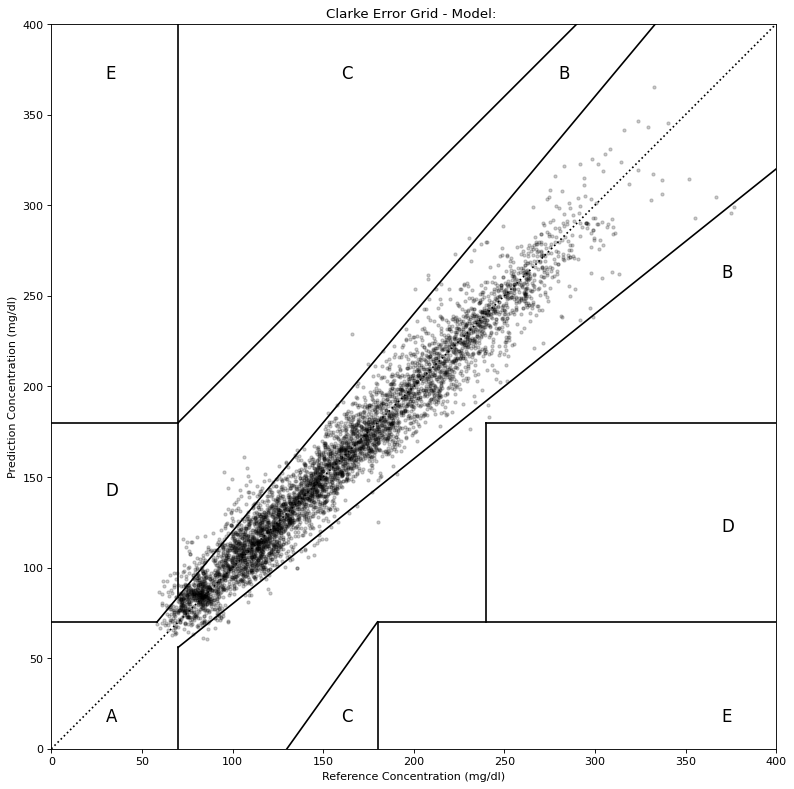

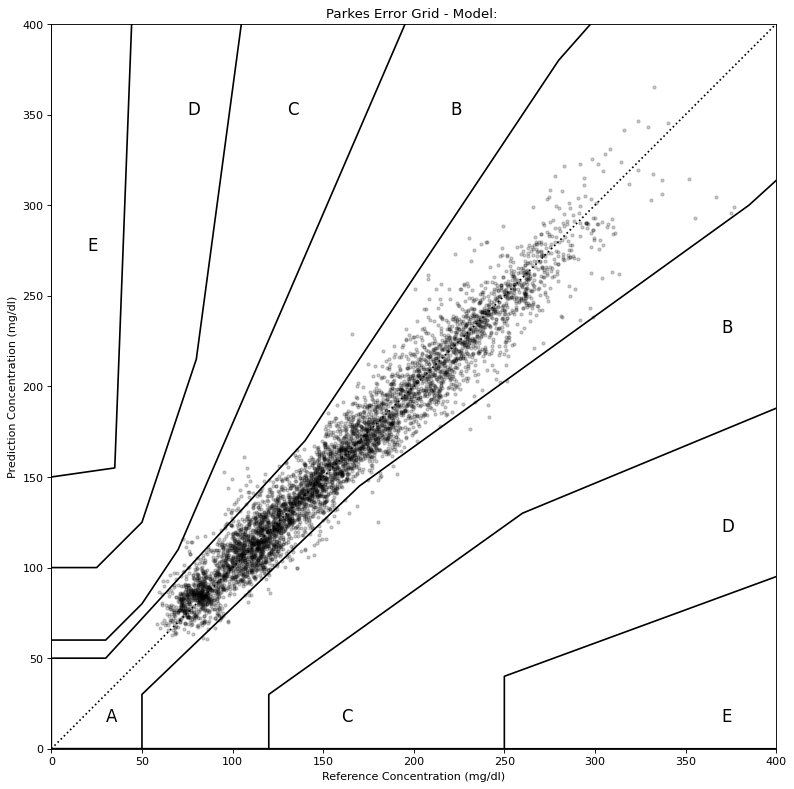

In [ ]:
# %% Evaluate model
# ---------------------------------------------------------------------
# EVALUATE THE MODEL
# ---------------------------------------------------------------------
evaluationConfiguration = {
    'distance': True,
    'hypo': True,
    'clarke': True,
    'parkes': True,
    'lag': True,
    'plotLag': True,
    'plotTimeseries': True
}
# ---------------------------------------------------------------------

evalObject = evaluateModel(data_obj, model)

import csv
if evaluationConfiguration['distance']:
    distance = evalObject.get_distanceAnalysis()
    w = csv.writer(open(model_figure_path / "distance.csv", "w"))
    for key, val in distance.items():
        w.writerow([key, val])

if evaluationConfiguration['hypo']:
    hypo = evalObject.get_hypoAnalysis()

if evaluationConfiguration['lag']:
    lag = evalObject.get_lagAnalysis(figure_path=model_figure_path)

if evaluationConfiguration['plotTimeseries']:
    evalObject.get_timeSeriesPlot(figure_path=model_figure_path)

if evaluationConfiguration['clarke']:
    clarkes, clarkes_prob = evalObject.clarkesErrorGrid(
        'mg/dl', figure_path=model_figure_path)

if evaluationConfiguration['parkes']:
    parkes, parkes_prob = evalObject.apply_parkes_error_grid(
        'mg/dl', figure_path=model_figure_path)


In [8]:
    w = csv.writer(open(model_figure_path / "hypo.csv", "w"))
    for key, val in hypo.items():
        w.writerow([key, val])


NameError: ignored